# Assigning a 'walk' radius for possible PUDO points of a trip request


Assigning working directory 

In [1]:
import os
cwd = os.getcwd()
os.chdir(os.path.join(cwd,'../../..'))

Local imports

In [2]:
import ExMAS.utils
import ExMAS.main
import pandas as pd
import pprint
import matplotlib.pyplot as plt
import osmnx as ox
import networkx as nx
from ExMAS.utils import inData as inData

Retrieving config file, graph, and demand 

In [3]:
params = ExMAS.utils.get_config('ExMAS/data/configs/ams-config-1.json') # load the default 
params.nP= 300
inData = ExMAS.utils.load_G(inData, params, stats=True)  # download the graph
inData = ExMAS.utils.load_albatross_csv(inData, params, sample=True)


In [4]:
inData = ExMAS.main(inData, params, plot = False)


22-04-21 10:14:48-INFO-Initializing pairwise trip shareability between 300 and 300 trips.
22-04-21 10:14:48-INFO-creating combinations
22-04-21 10:14:48-INFO-89700	 nR*(nR-1)
22-04-21 10:14:51-INFO-Reduction of feasible pairs by 99.66%
22-04-21 10:14:51-INFO-Degree 2 	Completed
22-04-21 10:14:51-INFO-trips to extend at degree 2 : 641
22-04-21 10:14:51-INFO-At degree 2 feasible extensions found out of 39 searched
22-04-21 10:14:51-INFO-Degree 3 	Completed
22-04-21 10:14:51-INFO-trips to extend at degree 3 : 39
22-04-21 10:14:51-INFO-At degree 3 feasible extensions found out of 2 searched
22-04-21 10:14:51-INFO-Degree 4 	Completed
22-04-21 10:14:51-INFO-trips to extend at degree 4 : 2
22-04-21 10:14:52-INFO-At degree 4 feasible extensions found out of 0 searched
22-04-21 10:14:52-INFO-Degree 5 	Completed
22-04-21 10:14:52-INFO-No more trips to exted at degree 5
22-04-21 10:14:53-INFO-Matching 300 trips to 982 rides in order to minimize u_veh
22-04-21 10:14:54-INFO-Problem solution: Optim

Specifying a walking radius

In [5]:
walk_speed = 1.389                     #m/s
walk_time  = 5                         #min
walk_dist  = round (walk_speed*60*5)   #metres

Function that searches for PUDO points that are 5 min walking from O/D of a request. The PUDO locations are stored within a Dataframe that can be easily retrieved later

In [6]:
def pudo_requests(_inData, walk_speed = 1.389, walk_time = 5):
    
    walk_dist = round(walk_speed*60*5)
    
    pudo = pd.DataFrame(index = range(len(_inData.sblts.requests)), columns = ['pax_id', 'origin', 'destination', \
                               'origin_nodes','destination_nodes','origin_dist','destination_dist'])
    pudo['pax_id'] = _inData.sblts.requests['index']
    pudo['origin'] = _inData.sblts.requests['origin'].tolist()
    pudo['destination'] = _inData.sblts.requests['destination'].tolist()
    pudo = pudo.astype(object)
    for i in range(len(pudo)):
        #origins = _inData.skim[pudo.iloc[i]['origin']][(_inData.skim[pudo.iloc[i]['origin']]<walk_dist) & (_inData.skim[pudo.iloc[i]['origin']]>0)].sort_values()
        origins = _inData.skim[pudo.iloc[i]['origin']][(_inData.skim[pudo.iloc[i]['origin']]<walk_dist)].sort_values()
        
        #destinations = _inData.skim[pudo.iloc[i]['destination']][(_inData.skim[pudo.iloc[i]['destination']]<walk_dist) & _inData.skim[pudo.iloc[i]['destination']]>0].sort_values()
        destinations = _inData.skim[pudo.iloc[i]['destination']][(_inData.skim[pudo.iloc[i]['destination']]<walk_dist)].sort_values()
        
        pudo.at[i,'origin_nodes'] = list(origins.index)
        pudo.at[i,'destination_nodes'] = list(destinations.index)
        
        pudo.at[i,'origin_dist']  = origins.tolist()
        pudo.at[i,'destination_dist'] = destinations.tolist()
        
    _inData.pudo = pudo
    
    return _inData


In [7]:
inData = pudo_requests(inData)

PUDO points can be quickly visualised using the function below. 

In [8]:
def plot_pudo_demand(_inData, params, s=10):
    
    fig, ax = ox.plot_graph(_inData.G, figsize=(40, 40), node_size=0, edge_linewidth=0.5,
                            show=False, close=False,
                            edge_color='grey', bgcolor = 'white' )

    for _, r in _inData.pudo.iterrows():
        ax.scatter(_inData.G.nodes[r.origin]['x'], _inData.G.nodes[r.origin]['y'], c='green', s=s*2.5, marker='o')
        ax.scatter(_inData.G.nodes[r.destination]['x'], _inData.G.nodes[r.destination]['y'], c='red', s=s*2.5,marker='>')
        for node in r.origin_nodes:                                                                                         #quite inefficient code
            ax.scatter(_inData.G.nodes[node]['x'], _inData.G.nodes[node]['y'], c='blue', s=s*0.5, marker = 'X',alpha=0.4)
        for node in r.destination_nodes:  
            ax.scatter(_inData.G.nodes[node]['x'], _inData.G.nodes[node]['y'], c='orange', s=s*0.5, marker = 'X',alpha=0.4)
    plt.scatter(_inData.G.nodes[inData.stats['center']]['x'], _inData.G.nodes[_inData.stats['center']]['y'], c='black',
               s=10 * s, marker='+')
    plt.title(
        'Demand in {} with origins marked in green, destinations in orange'.format(params.city))
    plt.show()  

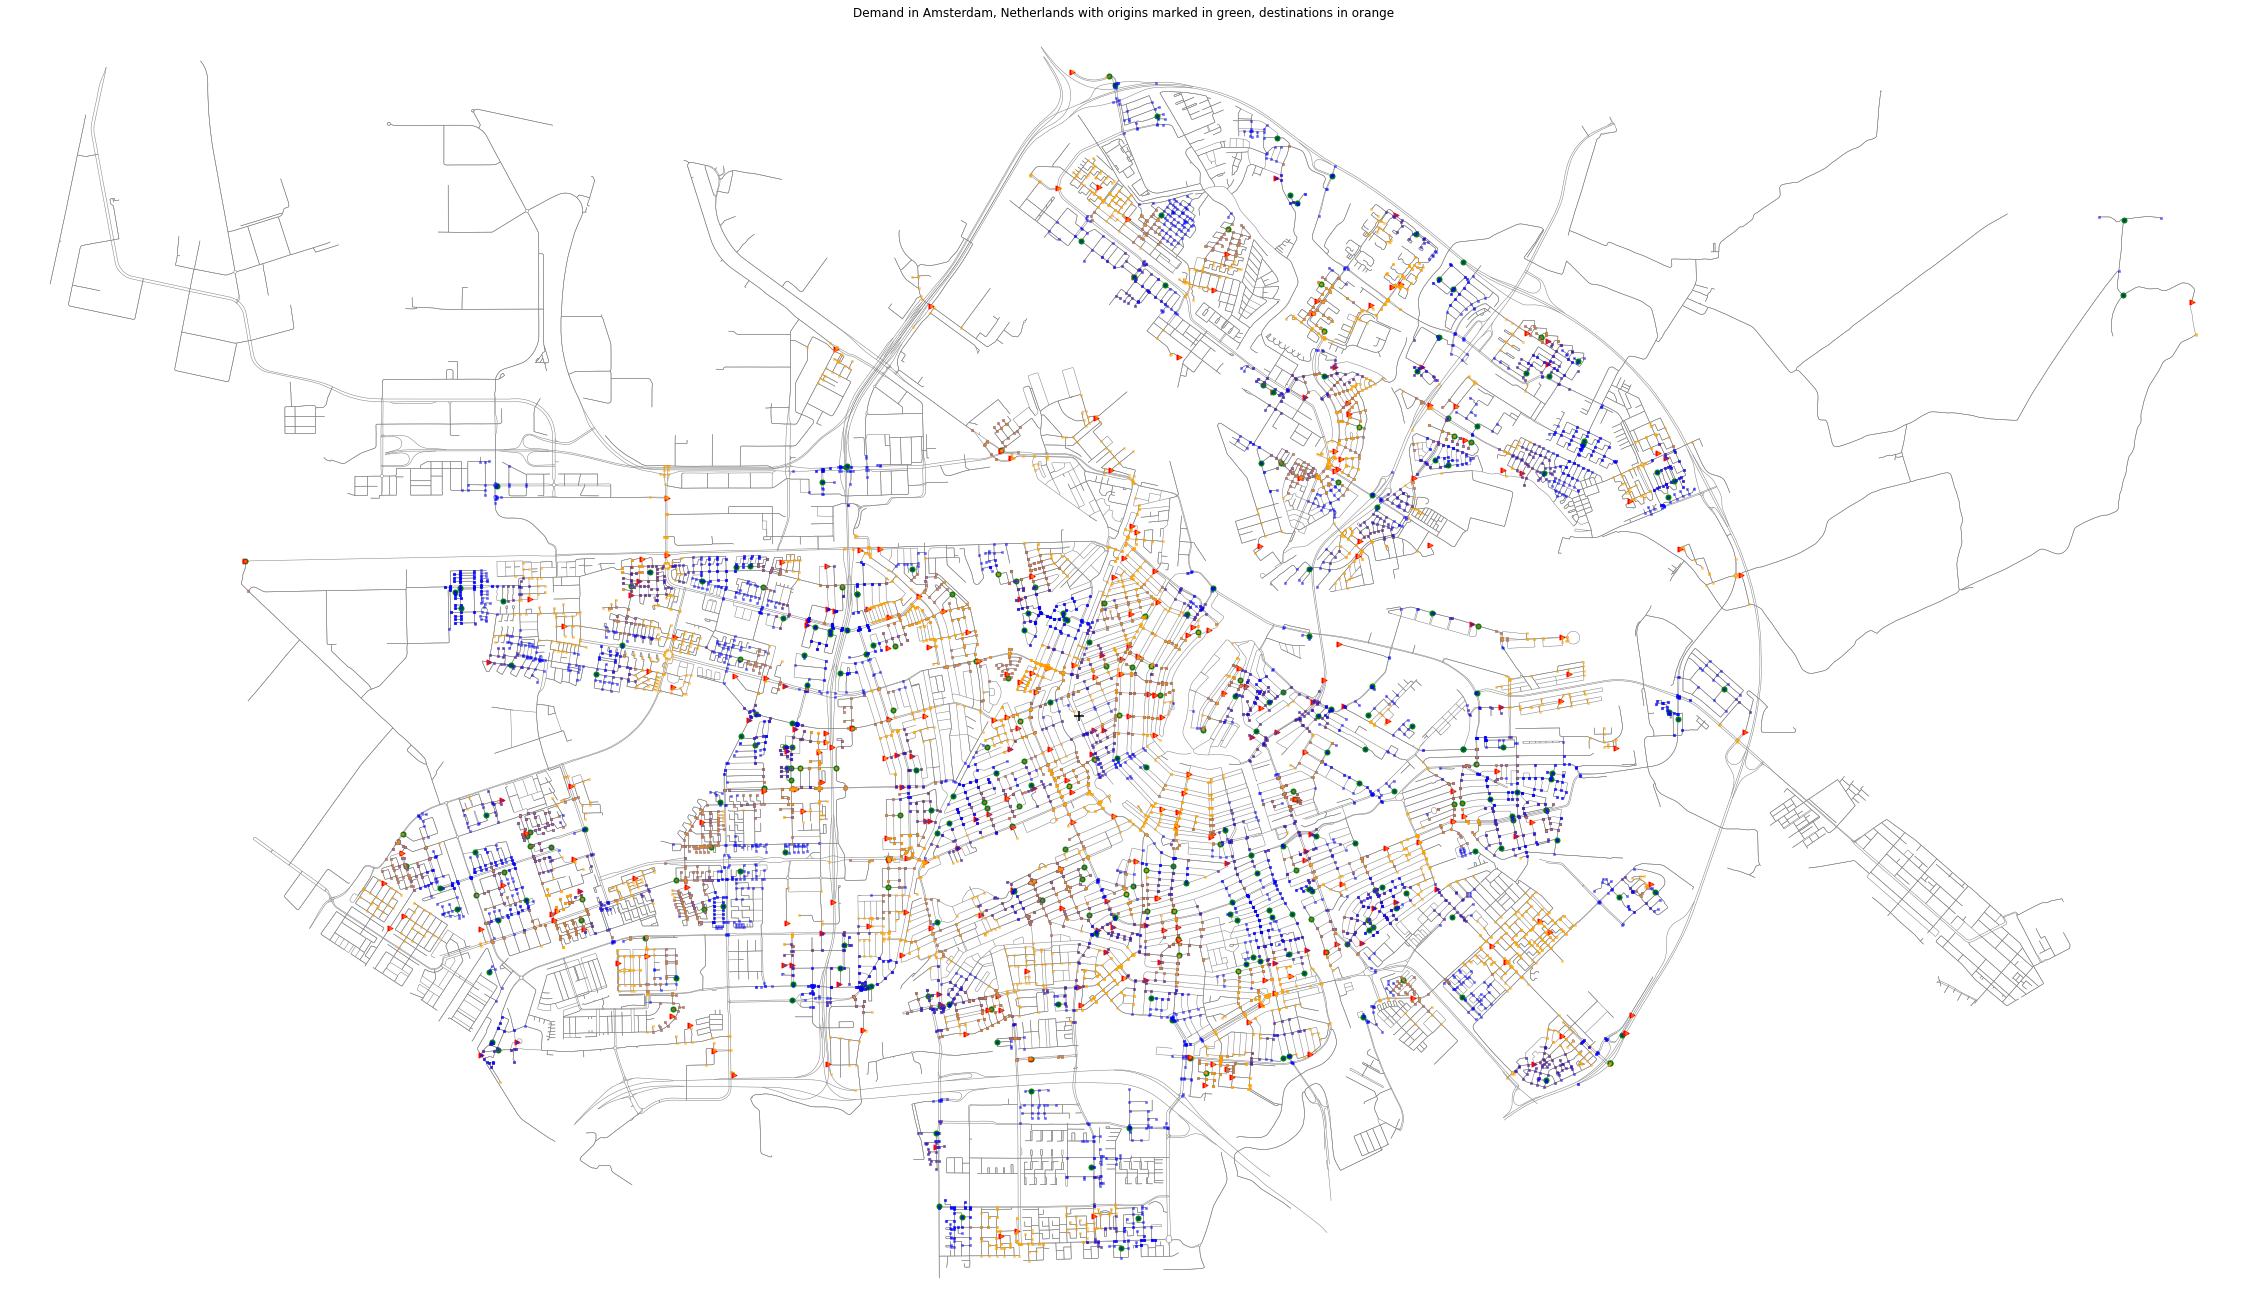

In [9]:
plot_pudo_demand(inData,params)

# Function for plotting the route 

In [10]:
  
def plot_map_rides(inData, ride_indexes, light=True, m_size=30, lw=3, fontsize = 10, figsize = (40,40)):
    import seaborn as sns

    from matplotlib.collections import LineCollection

    def make_schedule(t, r, p):
        columns = ['node', 'times', 'req_id','pudo_nodes', 'od']
        degree = 2 * len(t.indexes)
        df = pd.DataFrame(None, index=range(degree), columns=columns)
        x = t.indexes_orig
        s = [r.loc[i].origin for i in x] + [r.loc[i].destination for i in x]
        p = [p.iloc[i].origin_nodes for i in x] + [p.iloc[i].destination_nodes for i in x]      #retrieving pudo locs from PUDO DF
        df.node = pd.Series(s)                                                                                    # adding pudo to DF
        df.pudo_nodes = pd.Series(p)
        df.req_id = x + t.indexes_dest
        df.times = t.times
        df.od = pd.Series(['o'] * len(t.indexes) + ['d'] * len(t.indexes))
        return df


    def add_route(ax, route, color='grey', lw=2, alpha=0.5):
        # plots route on the graph alrready plotted on ax
        edge_nodes = list(zip(route[:-1], route[1:]))
        lines = []
        for u, v in edge_nodes:
            # if there are parallel edges, select the shortest in length
            data = min(G.get_edge_data(u, v).values(), key=lambda x: x['length'])
            # if it has a geometry attribute (ie, a list of line segments)
            if 'geometry' in data:
                # add them to the list of lines to plot
                xs, ys = data['geometry'].xy
                lines.append(list(zip(xs, ys)))
            else:
                # if it doesn't have a geometry attribute, the edge is a straight
                # line from node to node
                x1 = G.nodes[u]['x']
                y1 = G.nodes[u]['y']
                x2 = G.nodes[v]['x']
                y2 = G.nodes[v]['y']
                line = [(x1, y1), (x2, y2)]
                lines.append(line)
        lc = LineCollection(lines, colors=color, linewidths=lw, alpha=alpha, zorder=3)
        ax.add_collection(lc)

    s = inData.sblts.rides
    r = inData.sblts.requests
    G = inData.G
    p  = inData.pudo
    ts = [make_schedule(s.iloc[ride_index],r,p) for ride_index in ride_indexes]

    # t1 = make_schedule(s.iloc[1], r)
    # t2 = make_schedule(s[s.kind == 20].iloc[1], r)
    #t3 = make_schedule(s[s.kind == 31].iloc[3], r)



    G = inData.G
    fig, ax = ox.plot_graph(G, figsize=figsize, node_size=0, edge_linewidth=0.3,
                            show=False, close=False,
                            edge_color='grey',  bgcolor='white')

    #colors = {1: 'navy', 2: 'teal', 3: 'maroon', 4: 'black', 5: 'green', 6:'teal'}
    colors = sns.color_palette("Set2",6)


    for t in ts:

        orig_points_lats, orig_points_lons, dest_points_lats, dest_points_lons = [], [], [], []
        deg = t.req_id.nunique()
        count = 0
        for i in t.req_id.unique():
            count += 1
            r = t[t.req_id == i]

            o = r[r.od == 'o'].iloc[0].node
            d = r[r.od == 'd'].iloc[0].node
            
            o_pudo = r[r.od == 'o'].iloc[0].pudo_nodes
            d_pudo = r[r.od == 'd'].iloc[0].pudo_nodes

            if not light:
                ax.annotate('o' + str(i), (G.nodes[o]['x'] * 1.0001, G.nodes[o]['y'] * 1.00001), fontsize = fontsize,
                    bbox = dict(facecolor='white', alpha=0.7, edgecolor='none'))
                ax.annotate('d' + str(i), (G.nodes[d]['x'] * 1.0001, G.nodes[d]['y'] * 1.00001), fontsize = fontsize,
                    bbox = dict(facecolor='white', alpha=0.7, edgecolor='none'))
            route = nx.shortest_path(G, o, d, weight='length')
            add_route(ax, route, color='black', lw=lw / 2, alpha=0.3)
            ax.scatter(G.nodes[o]['x'], G.nodes[o]['y'], s=m_size, c=[colors[deg]], marker='o')
            ax.scatter(G.nodes[d]['x'], G.nodes[d]['y'], s=m_size, c=[colors[deg]], marker='>')
            for o_p in o_pudo:
                ax.scatter(G.nodes[o_p]['x'], G.nodes[o_p]['y'], s=m_size,alpha = 1, c=[colors[deg]], marker='x')
            for d_p in d_pudo:
                ax.scatter(G.nodes[d_p]['x'], G.nodes[d_p]['y'], s=m_size,alpha = 1, c=[colors[deg]], marker='x')
        routes = list()  # ride segments
        o = t.node.values[0]
        for d in t.node.values[1:]:
            routes.append(nx.shortest_path(G, o, d, weight='length'))
            o = d
        for route in routes:
            add_route(ax, route, color=[colors[deg]], lw=lw, alpha=0.7)
    plt.tight_layout()
    plt.savefig('map.png', dpi = 300)

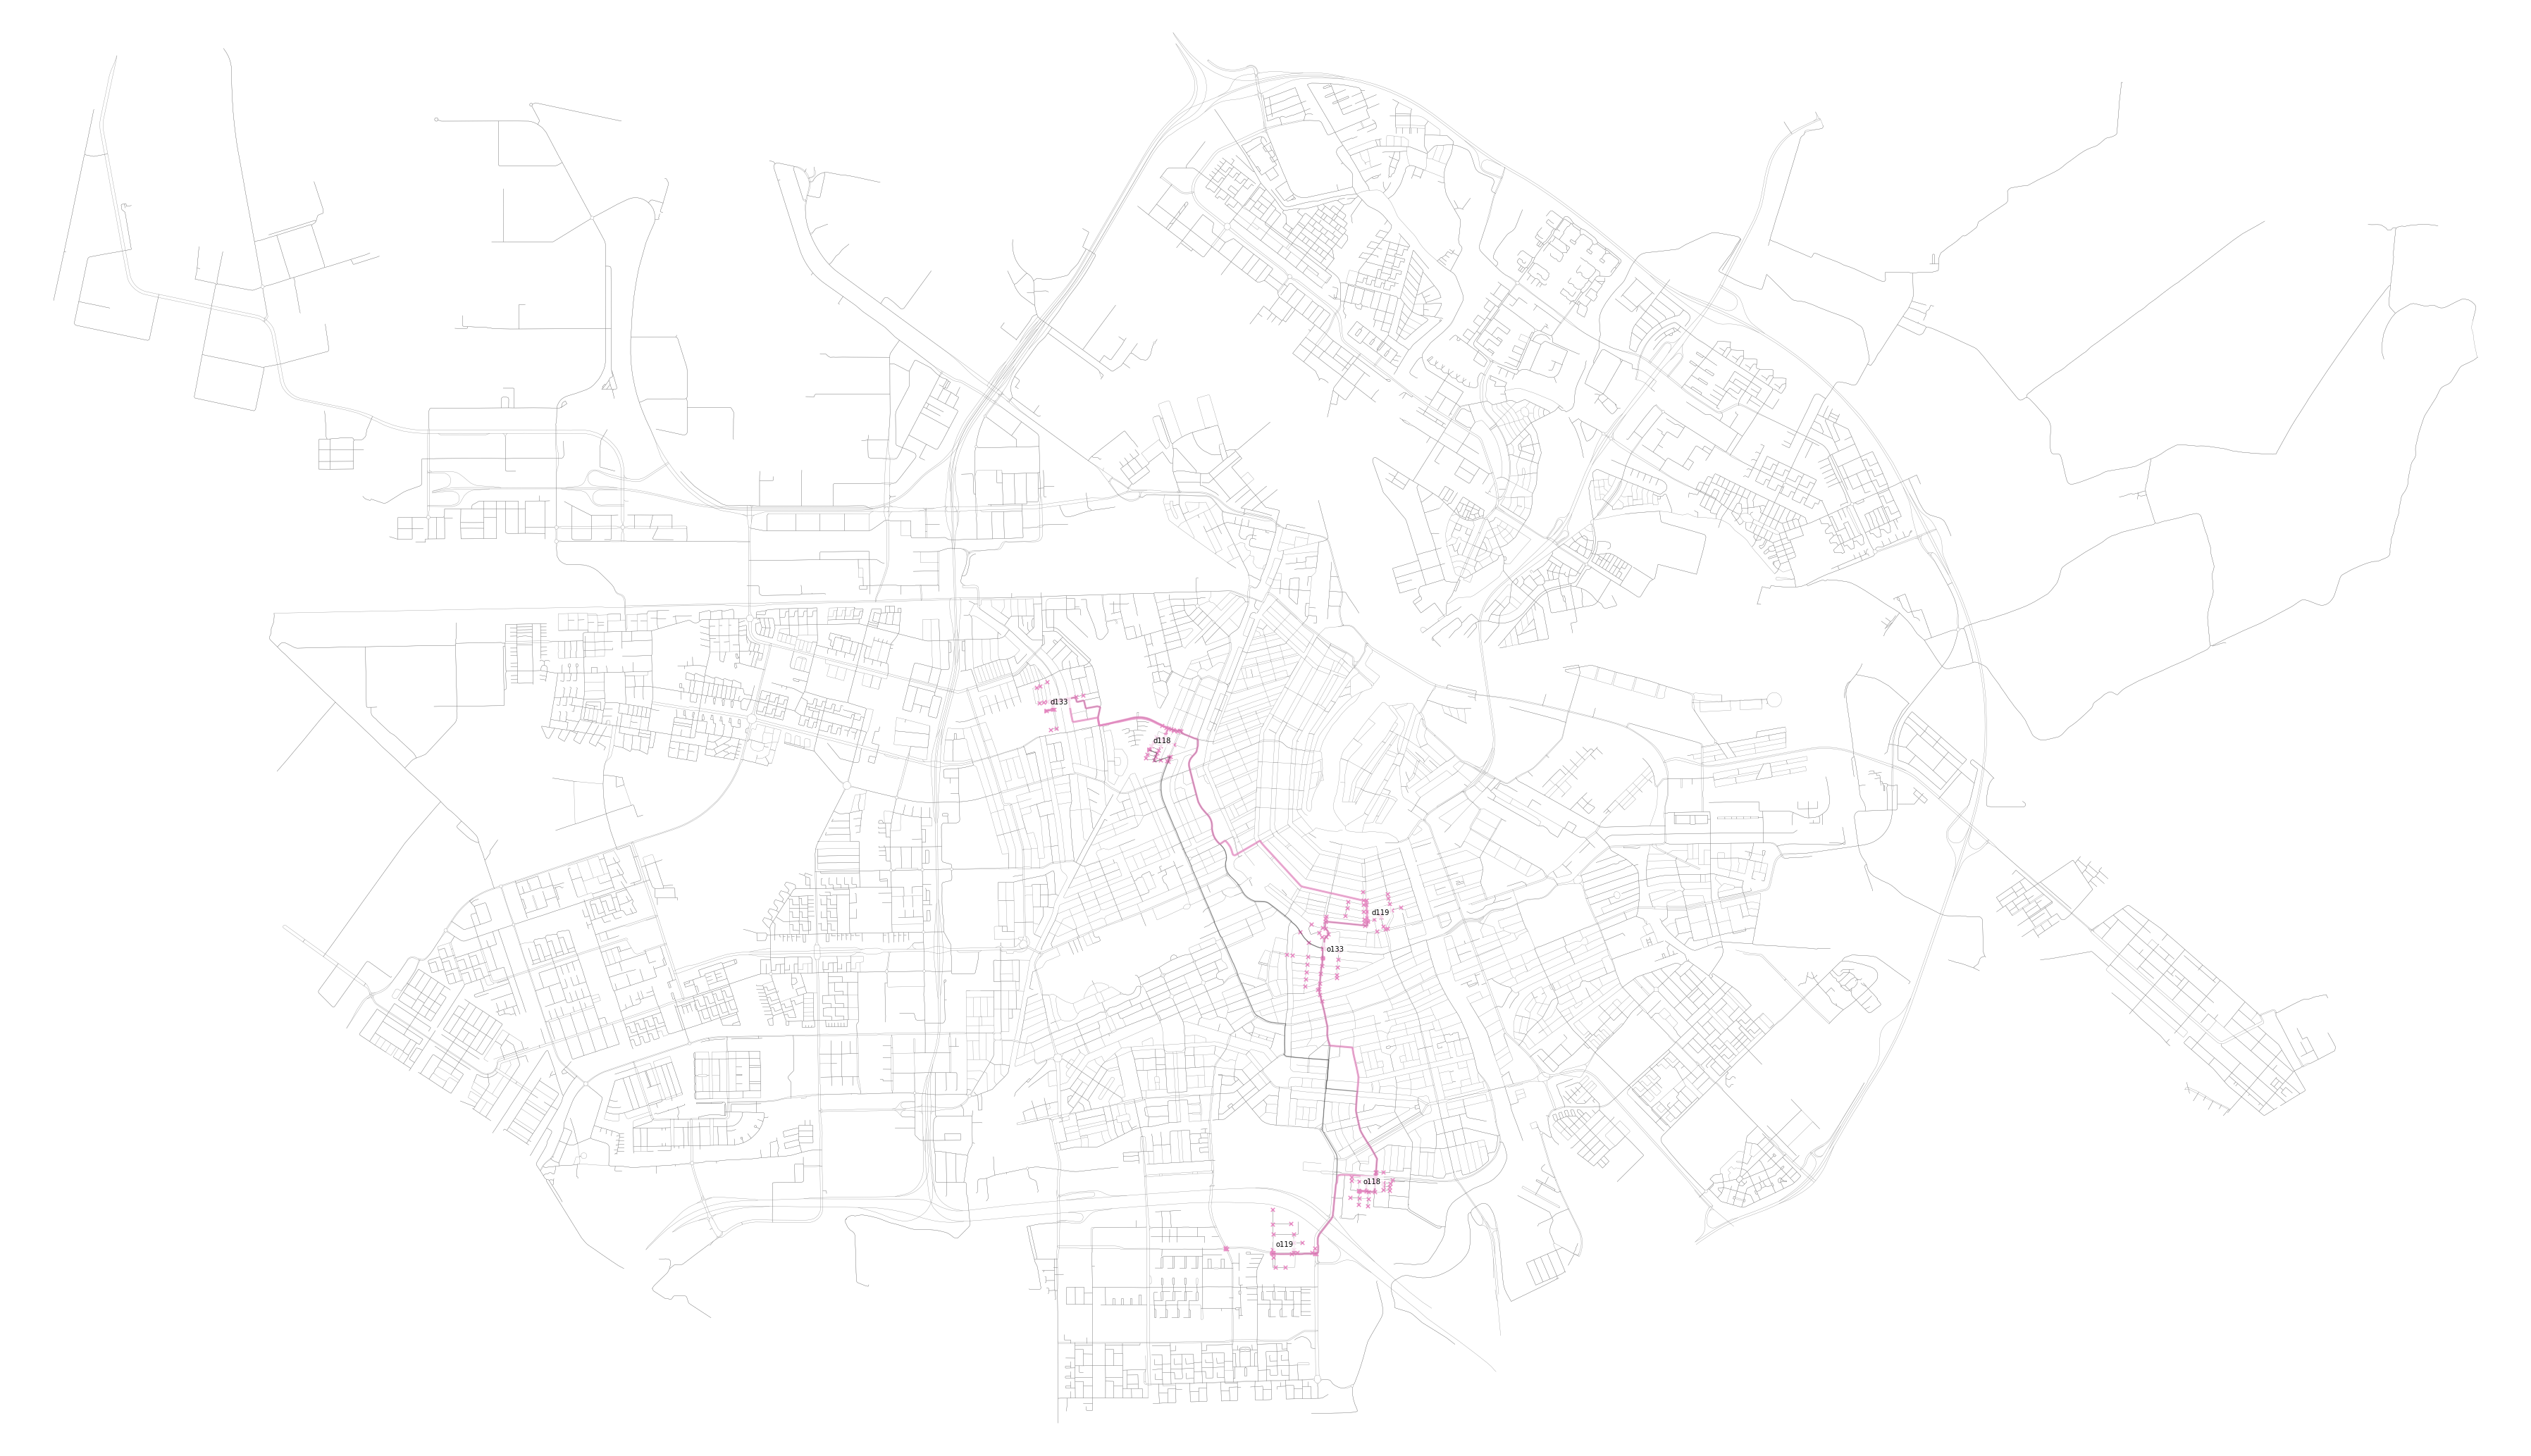

In [19]:
plot_map_rides(inData, [959], light=False, m_size=30, lw=3, fontsize = 10, figsize = (50,50))

Selected highest degree ride -> used as sample ride for optimising

In [18]:
r = inData.sblts.rides[inData.sblts.rides.degree!=1]
r = inData.sblts.rides[inData.sblts.rides.selected == 1]

r = r.iloc[-4]                                                       #last feasbile shared ride selected
r

indexes                                              [119, 118, 133]
u_pax                                                        24.2524
u_veh                                                           1238
kind                                                              32
u_paxes                     [7.069125, 11.630675, 5.552574999999999]
times                               [1695.5, 224, 311, 91, 397, 215]
indexes_orig                                         [119, 118, 133]
indexes_dest                                         [119, 133, 118]
degree                                                           NaN
index                                                            959
lambda_r                                                    0.237685
PassHourTrav_ns                                                 1624
row                [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
selected                                                           1
Name: 959, dtype: object

# Brute-force Search for shortest path

An attempt at going through every possible PUDO for a given origin/destination index. The shortest distance would be taken as the optimal route.

This would result in a very inefficient algorithm, which also why I did not complete it. 

In essence I was trying to create a table that resembles this:



In [15]:




for nod in o_1.index:
    lst = []
    lst.append(nod)
    dist = o_1[nod]
    for i,j in enumerate(r.indexes[1:]):   
        o = inData.pudo.iloc[j].origin_nodes           #List of pudo origins for a index
    
        if j === r.indexes[-1]                         #are destination indeces alaways `mirrored' to origin indeces? 
            for i,j in enumerate(r.indexes[:-1]):
        
    #if i==0:
                                                    

'''PUDO LOCATIONS           | Distance (m)           #sample table 
------------------------------------------
[node_id_0, node_id_1, ...] | 23550
...                         | ...            '''    
    
    

SyntaxError: invalid syntax (<ipython-input-15-e262845d7919>, line 8)

# Dijkstra algorithm for a simple graph

Dijkstra algorithm would be able to find the global optimium of a given graph. A dijkstra algorithm is already used within osmnx to calulcate shortest path, but something similar would be needed to assess the shortest path of all the nodes. 

If this were to be used, the graph should be set up for all the possible PUDO points


In [ ]:
graph = {'a':{'b':10,'c':3},'b':{'c':1,'d':2}\                                                # sample graph
         ,'c':{'b':4,'d':8,'e':2},'d':{'e':7},'e':{'d':9}}
    
def dijkstra(graph,start,goal):
    shortest_distance ={}              
    predecessor = {}                   
    unseenNodes = graph                                                                       # run through all until every node has been checked
    infinity = float('inf')
    path = []
    
    for node in unseenNodes:
        shortest_distance[node] = infinity                                                    # assigning infinity to nodes in proximity
    shortest_distance[start] = 0    
    
    while unseenNodes:                                                                       # keep running until unseennodes is empty
        minNode = None
        for node in unseenNodes:                                                             # go through the nodes in unseen nodes     
            if minNode is None:
                minNode =node                                                                # first node is the minnode
            elif shortest_distance[node]<shortest_distance[minNode]:                         # assigning new node to minnode
                minNode=node
                
        for childNode, weight in graph[minNode].items():                                     # for current minode, examine connecting nodes 
            if weight + shortest_distance[minNode]<shortest_distance[childNode]:             # if distance from min node shorter than child node, assign child node as min node
                
                shortest_distance[childNode] = weight + shortest_distance[minNode]
                predecessor[childNode] = minNode
                
        unseenNodes.pop(minNode)                                                             # break while loop
        
    currentNode = goal
    while currentNode != start:                                                              # run as long as current node is not equal to start node
        try:
            path.insert(0,currentNode)                                                       # insert nodes that are in shortest path
            currentNode = predecessor[currentNode]
        except KeyError:
            print('Path not reachable')
            break
    
    path.insert(0,start)
    if shortest_distance[goal] != infinity:
        print('Shortest distance is ' + str(shortest_distance[goal]))
        print('and the path is' + str(path))
                
    
dijkstra(graph, 'a', 'd')

# Skim Matrix

In [38]:
O_0 = inData.pudo.iloc[r.indexes[0]].origin_nodes
O_1 = inData.pudo.iloc[r.indexes[1]].origin_nodes

In [39]:
lil_skim=inData.skim.loc[O_0][O_1]


In [21]:
graph = {}
for i,trip_o in enumerate(r.indexes):
    #O_0 = inData.pudo.iloc[r.indexes[0]].origin
    if i<(len(r.indexes)-1):
        O_0 = inData.pudo.iloc[r.indexes[i]].origin_nodes
        O_1 = inData.pudo.iloc[r.indexes[i+1]].origin_nodes
    
        D_0 = inData.pudo.iloc[r.indexes_dest[i]].destination_nodes
        D_1 = inData.pudo.iloc[r.indexes_dest[i+1]].destination_nodes
        graph[i]  = inData.skim.loc[O_0][O_1]
            
        graph[i+(len(r.indexes))] = inData.skim.loc[D_0][D_1]
    else:
        O_0 = inData.pudo.iloc[r.indexes[-1]].origin_nodes
        D_0 = inData.pudo.iloc[r.indexes_dest[0]].destination_nodes
        graph[i]  = inData.skim.loc[O_0][D_0]

    

In [20]:
idxmin = graph[0].stack().idxmin()
distances = []

for i,g in enumerate(graph):
    if i == 0:
        idxmin = graph[i].stack().idxmin()
        distances.append(graph[i].loc[idxmin])
    else:
        idxmin = ( idxmin[1],graph[i].loc[idxmin[1]].idxmin())
        distances.append(graph[i].loc[idxmin])
        #idxmin = graph[i].stack().idxmin()


NameError: name 'graph' is not defined

In [ ]:
while optimum=False:
    
    for i,g in enumerate(graph):
        if i == 0:
            #idxmin = graph[i].stack().idxmin()
            skim_sort = graph[i].stack().sort_values()
            distances.append(graph[i].loc[skim_sort.iloc[0]])
        else:
            skim_sort = graph[i].stack().sort_values()
            idxmin = ( idxmin[1],graph[i].loc[idxmin[1]].idxmin())
            distances.append(graph[i].loc[idxmin])
            #idxmin = graph[i].stack().idxmin()

In [93]:
graph[0].stack().idxmin()

(1000830542, 1726034559)

In [91]:
a = graph[0].where(graph[0]==323).dropna(how='all').dropna(axis=1)

In [116]:
a.index

Int64Index([1000830542], dtype='int64')

In [114]:
mini = graph[0].stack().sort_values().iloc[0]

AttributeError: 'Series' object has no attribute 'stack'

In [28]:
for i,g in enumerate(graph):
    graph[i] = graph[i].stack().sort_values()

In [30]:
distances   = [0]*(len((r.indexes))+(len(r.indexes)-1))
nodes       = []

predecessor = [float('inf')]

i  = j = k = l = m = 0

for i, d_0 in enumerate(graph[0]):
    dist_0  = d_0
    nodes_0 = graph[0].where(graph[0]==dist_0).dropna(how='all').head(n=1)
    distances[0]=dist_0
    if sum(predecessor)< sum(distances):
        break
    for j, d_1 in enumerate(graph[1].loc[nodes_0.index[0][1]]):
        dist_1  = graph[1].loc[nodes_0.index[0][1]].iloc[j]
        nodes_1 = graph[1].where(graph[1]==dist_1).dropna(how='all').head(n=1)
        distances[1]=dist_1

        if sum(predecessor)< sum(distances) or abs(sum(predecessor)-sum(distances))<=1500:
            distances[1] = 0
            break
        for k, d_2 in enumerate(graph[2].loc[nodes_1.index[0][1]]):
            dist_2 = graph[2].loc[nodes_1.index[0][1]].iloc[k]
            nodes_2 = graph[2].where(graph[2]==dist_2).dropna(how='all').head(n=1)
            distances[2]=dist_2
            
            if sum(predecessor)< sum(distances):
                distances[2] = 0
                break
            for l, d_3 in enumerate(graph[3].loc[nodes_2.index[0][1]]):
                dist_3  = graph[3].loc[nodes_2.index[0][1]].iloc[l]
                nodes_3 = graph[3].where(graph[3]==dist_3).dropna(how='all').head(n=1)
                distances[3]=dist_3

                if sum(predecessor)< sum(distances):
                    distances[3] = 0
                    break
                for m, d_4 in enumerate(graph[4].loc[nodes_3.index[0][1]]):
                    dist_4 = graph[4].loc[nodes_3.index[0][1]].iloc[m]
                    nodes_4 = graph[4].where(graph[4]==dist_4).dropna(how='all').head(n=1)
                    distances[4]=dist_4
                    print(sum(distances), sum(predecessor))
                    if i == j == k == l == m == 0:
                        predecessor = distances.copy()
                        #print(predecessor)
                    elif sum(predecessor)< sum(distances):
                        distances[4] = 0
                        break    
                    elif sum(predecessor)>= sum(distances):  
                        predecessor = distances.copy()
                        break

    
print(distances, predecessor)

7728 inf
7764 7728
7456 7728
7466 7456
7206 7456
7466 7206
7206 7206
7466 7206
7206 7206
7466 7206
7206 7206
7473 7206
7213 7206
7461 7206
7509 7206
7214 7206
7214 7206
7567 7206
7213 7206
7214 7206
7214 7206
7509 7206
7213 7206
7214 7206
7762 7206
7555 7206
7329 7206
7213 7206
7555 7206
7555 7206
7435 7206
7433 7206
7509 7206
7509 7206
7708 7206
7552 7206
7368 7206
7699 7206
7685 7206
7674 7206
7855 7206
8105 7206
8194 7206
7962 7206
7947 7206
7962 7206
8206 7206
7946 7206
7947 7206
8431 7206
8242 7206
7946 7206
7947 7206
8495 7206
8334 7206
8033 7206
8178 7206
8288 7206
8289 7206
8400 7206
8439 7206
8391 7206
8391 7206
8441 7206
8391 7206
8294 7206
8284 7206
8427 7206
8408 7206
7884 7206
7625 7206
7872 7206
7920 7206
7625 7206
7625 7206
7966 7206
7976 7206
7625 7206
7625 7206
7920 7206
7679 7206
7625 7206
7707 7206
7967 7206
7741 7206
7625 7206
7966 7206
7967 7206
7847 7206
8067 7206
7966 7206
7966 7206
8119 7206
8155 7206
8171 7206
8111 7206
8174 7206
8086 7206
8000 7206
7740 7206
7

In [27]:
nodes_0

,46245188,46245248,46245005,46242668,46244888,46248098,4080260652,46247750,46242315,46242790,...,46244786,46251234,1343306045,46246237,46247279,46245306,46251015,46246150,46248207,46245008


In [26]:
graph[1]

,5805311950,46321108,5805311952,5802352869,5802352868,46324098,46318613,46330373,46320660,863195548,...,7191482452,6949114046,46317209,5805453835,46313942,6949114047,46318165,46336019,46330376,46334874
46245188,2370,2306,2451,2458,2459,2499,2238,2770,2726,2587,...,2593,2734,2396,1996,2289,2752,2374,2709,2562,2782
46245248,2379,2315,2460,2466,2468,2508,2247,2778,2735,2595,...,2602,2743,2405,2005,2298,2760,2383,2718,2571,2791
46245005,2315,2250,2395,2402,2404,2443,2182,2714,2671,2531,...,2538,2679,2341,1941,2234,2696,2319,2654,2507,2726
46242668,2433,2368,2513,2520,2522,2561,2300,2832,2789,2649,...,2655,2797,2459,2058,2352,2814,2437,2772,2624,2844
46244888,2292,2228,2373,2380,2381,2421,2160,2692,2648,2509,...,2515,2657,2319,1918,2211,2674,2296,2631,2484,2704
46248098,2463,2398,2543,2550,2552,2591,2330,2862,2819,2679,...,2685,2827,2489,2088,2382,2844,2467,2802,2654,2874
4080260652,2487,2423,2568,2575,2576,2616,2355,2887,2843,2704,...,2710,2851,2513,2113,2406,2869,2491,2826,2679,2899
46247750,2398,2334,2479,2486,2487,2527,2266,2798,2754,2615,...,2621,2762,2424,2024,2317,2780,2402,2737,2590,2810
46242315,2354,2290,2435,2441,2443,2483,2222,2753,2710,2570,...,2577,2718,2380,1980,2273,2735,2358,2693,2546,2766
46242790,2509,2444,2589,2596,2598,2637,2376,2908,2865,2725,...,2731,2873,2535,2135,2428,2890,2513,2848,2701,2920


In [202]:
len(r.indexes)

3

In [200]:
[0]*len((r.indexes))*(len(r.indexes)-2)

[0, 0, 0]

In [191]:
graph[4].loc[nodes_3.index[0][1]].iloc[0]


460

In [99]:
graph[0]

1000830542  1726034559     323
833985449   1726034559     334
1000830542  46334868       335
833985447   1726034559     345
833985449   46334868       346
                          ... 
2004730847  46329508      1659
1691713871  46330612      1667
            46328162      1668
            46332001      1706
            46329508      1707
Length: 775, dtype: int64

In [101]:
graph[0].loc[1000830542].iloc[0]

323

In [153]:
nodes_0 = graph[0].where(graph[0]==323).dropna(how='all')

In [154]:
nodes_0


1000830542  1726034559    323.0
dtype: float64

In [168]:
for i in range(5):    
    print(i)
    for val in "string":
        if val == "i":
            break
        print(val)


0
s
t
r
1
s
t
r
2
s
t
r
3
s
t
r
4
s
t
r


In [240]:
for val in "string":
    if val == "i":
        break
    print(val)

s
t
r


In [157]:
a = (1,3,4)

In [160]:
a[2]

4